<a href="https://colab.research.google.com/github/Rizvonium/ELM-Differential-Equations/blob/main/final_paper_four_problems_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

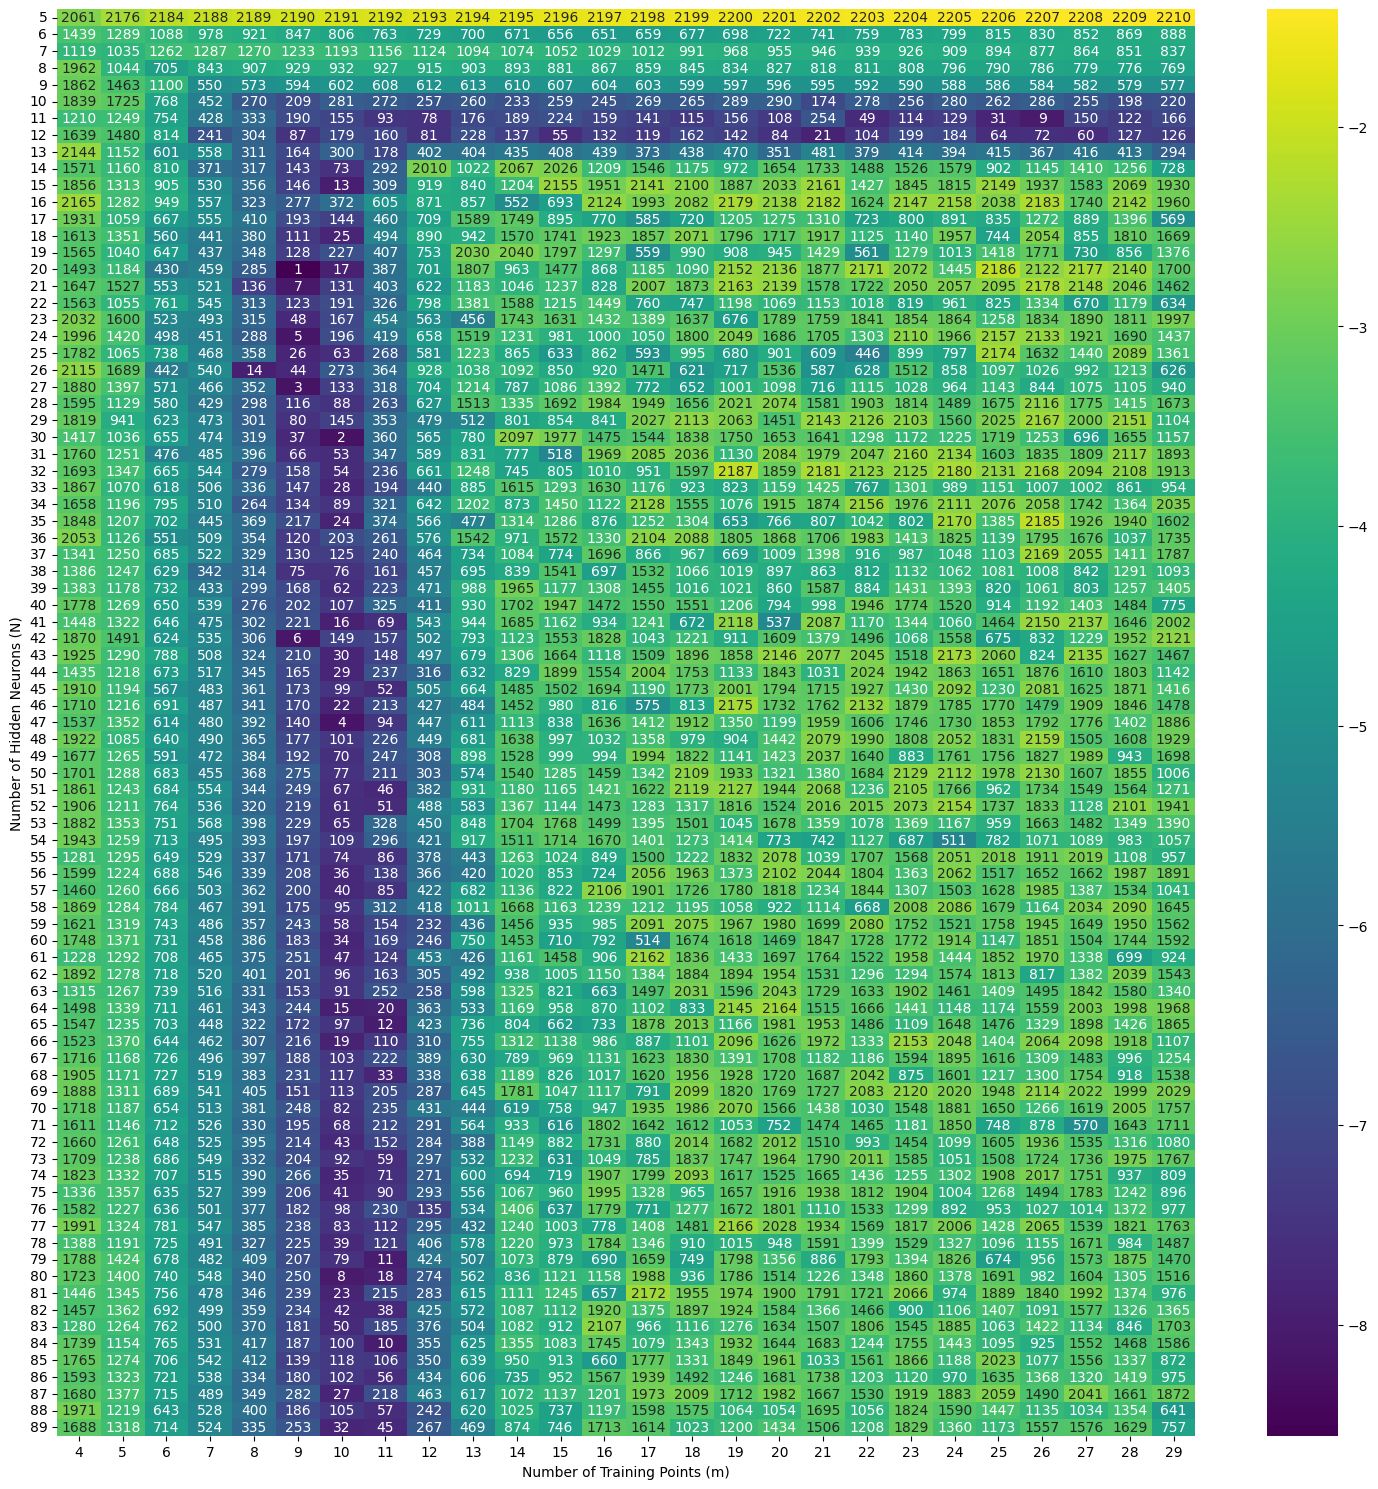

Log10(RMSE) Heatmap
(Numbers indicate rank: 1 = smallest)


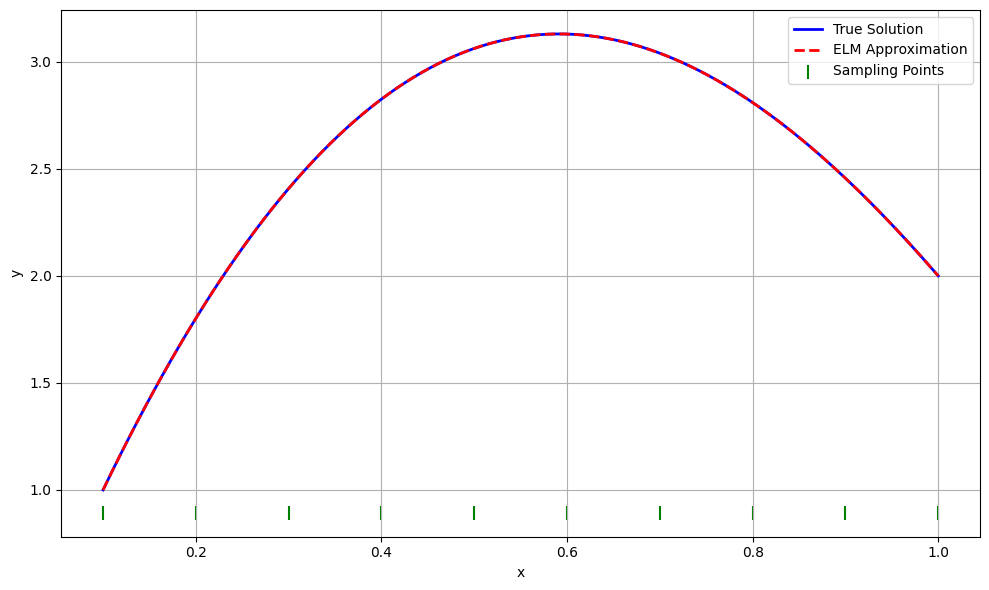

Solution Comparison (N=80, m=10)


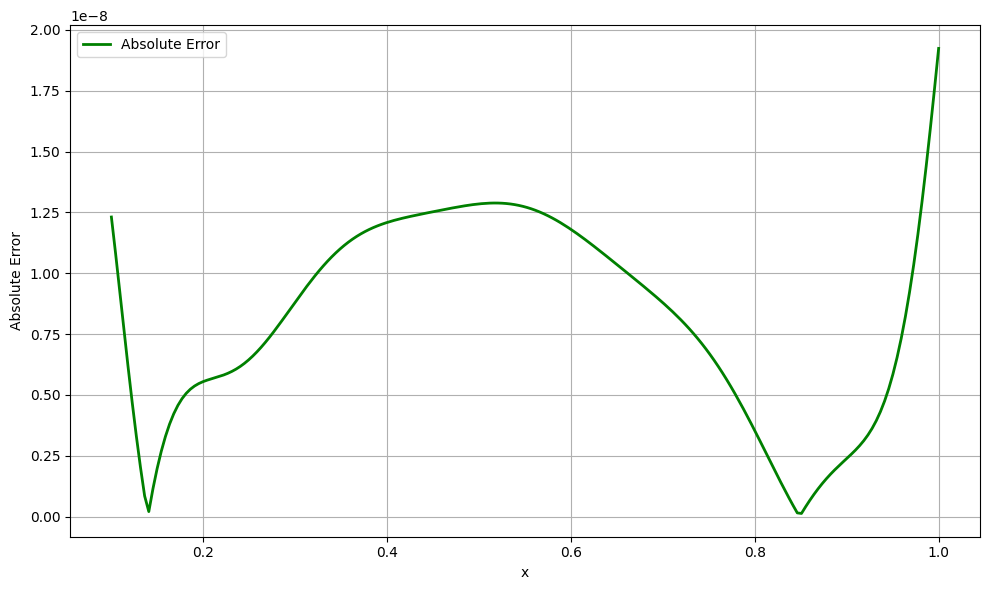

Error Distribution (N=80, m=10)
MAE: 0.0000000192
RMSE: 0.0000000092
Integral Error: 0.0000000073


<ipython-input-1-bf8964379bd9>:29: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integral_error = trapz(absolute_error, x_test)


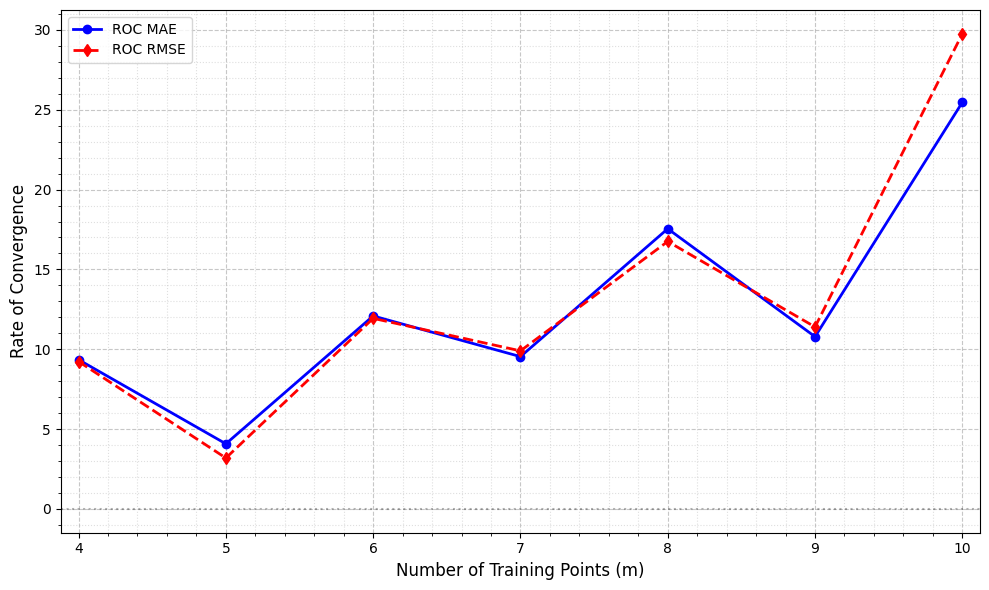

Rate of Convergence Analysis (N=80)


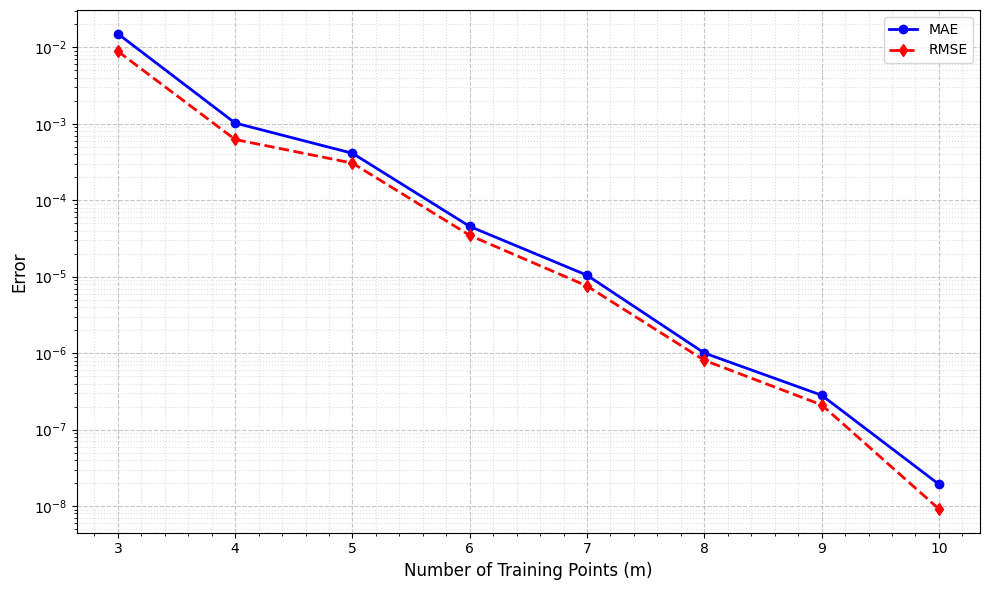

Error Analysis (N=80)

Error values up to m = 10
m values: [3, 4, 5, 6, 7, 8, 9, 10]
MAE values: [0.015063059944765644, 0.0010234505324100418, 0.0004117587724148386, 4.545081417317576e-05, 1.0443032846918499e-05, 1.0028079646673405e-06, 2.81390393652714e-07, 1.9236060078142714e-08]
RMSE values: [0.008882013831348977, 0.0006235257901116008, 0.00030595637059654707, 3.471650703423243e-05, 7.546281745657072e-06, 8.058272394559562e-07, 2.1046399112522659e-07, 9.1516335176406e-09]

Best combination with minimum RMSE error: N=20, m=9


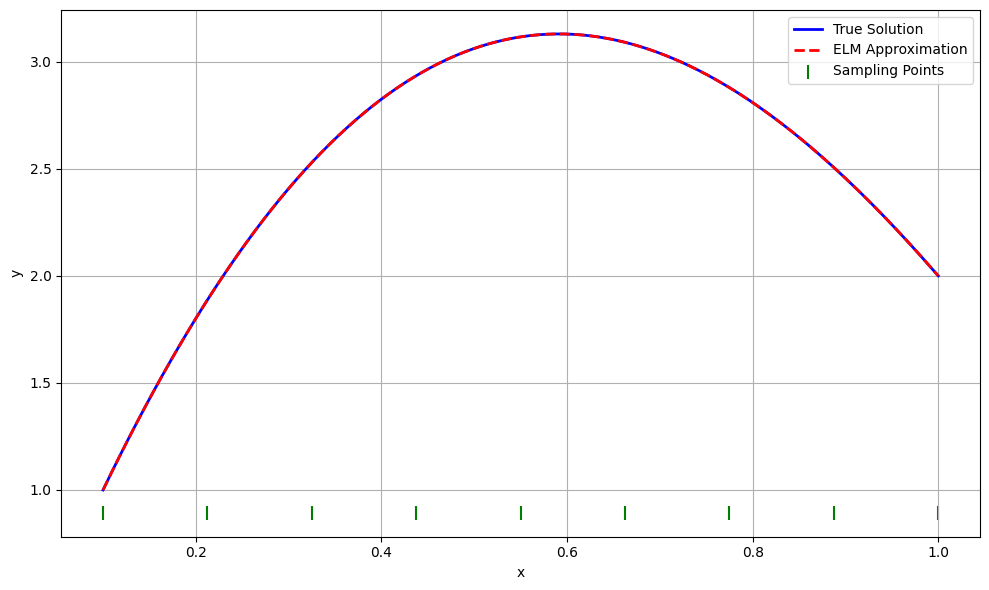

Solution Comparison (N=20, m=9)


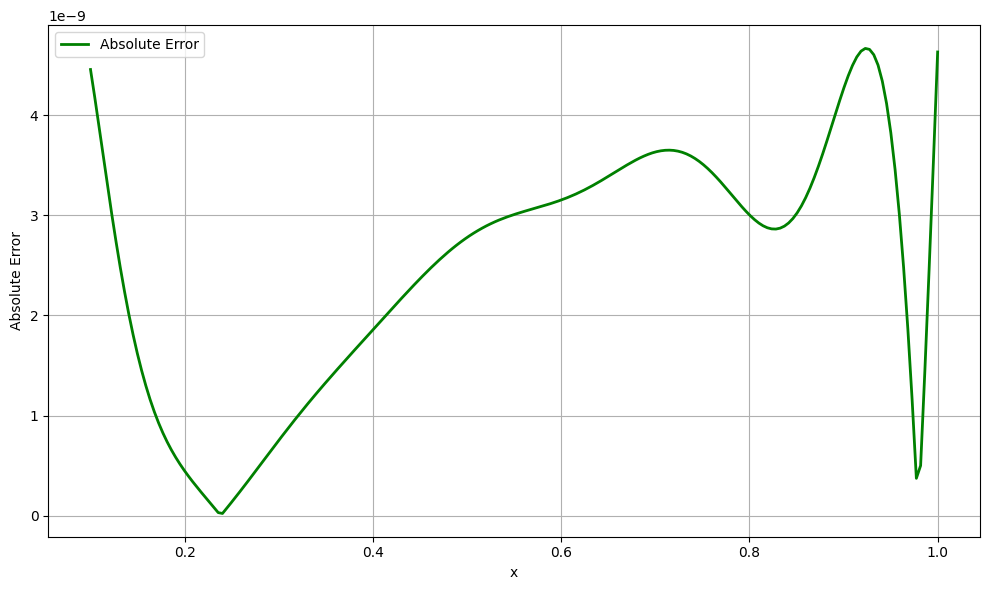

Error Distribution (N=20, m=9)
MAE: 0.0000000047
RMSE: 0.0000000028
Integral Error: 0.0000000022

Results for N = 80
    m             MAE            RMSE         ROC MAE        ROC RMSE
--------------------------------------------------------------------------------
    3    1.506306e-02    8.882014e-03             N/A             N/A
    4    1.023451e-03    6.235258e-04        9.347352        9.233782
    5    4.117588e-04    3.059564e-04        4.080321        3.190536
    6    4.545081e-05    3.471651e-05       12.087473       11.936204
    7    1.044303e-05    7.546282e-06        9.540637        9.900445
    8    1.002808e-06    8.058272e-07       17.547417       16.752172
    9    2.813904e-07    2.104640e-07       10.789468       11.398541
   10    1.923606e-08    9.151634e-09       25.464533       29.758607


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_bvp, trapz
import seaborn as sns

seed = 42
# Parameters
a, b = 0.1, 1
A, B = 1, 2
wb = 2
#x^2y"-2xy'+2y=6x^4 y(0.1)=1 y(1)=2
# Define ranges for N and m
N_values = range(5, 90, 1)
m_values = range(3, 30)
m_heatmap_values = range(4, 30)  # Heatmap starts from m = 4

def a2(x): return x**2
def a1(x): return -2*x
def a0(x): return 2
def f_func(x, y): return 6*x**4
def sigmoid(x): return 1 / (1 + np.exp(-x))
def MAE(y_true, y_pred): return np.max(np.abs(y_true - y_pred))
def RMSE(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def convergence_rate(E_n1, E_n2, n1, n2): return np.log(E_n1 / E_n2) / np.log(n2 / n1)

def calculate_integral_error(y_true, y_approx, x_test):
  absolute_error = np.abs(y_true - y_approx)
  integral_error = trapz(absolute_error, x_test)
  return integral_error

def elm_solver(m, N, a, b, A, B, u, w):
  x_train = np.linspace(a, b, m)
  f_x = f_func(x_train, 0)

  H = np.zeros((m+2, N))
  for i in range(m):
      x = x_train[i]
      for j in range(N):
          phi = sigmoid(x * u[j] + w[j])
          phi_prime = u[j] * sigmoid(x * u[j] + w[j]) * (1 - sigmoid(x * u[j] + w[j]))
          phi_double_prime = (u[j]**2) * sigmoid(x * u[j] + w[j]) * (1 - sigmoid(x * u[j] + w[j])) * (1 - 2 * sigmoid(x * u[j] + w[j]))
          H[i, j] = a2(x) * phi_double_prime + a1(x) * phi_prime + a0(x) * phi

  for j in range(N):
      H[-2, j] = sigmoid(a * u[j] + w[j])
      H[-1, j] = sigmoid(b * u[j] + w[j])

  beta = np.zeros(m+2)
  beta[:m] = f_x
  beta[-2] = A
  beta[-1] = B

  V = np.linalg.pinv(H) @ beta

  def y_approx(x):
      return sum(V[j] * sigmoid(u[j] * x + w[j]) for j in range(N))

  return y_approx

def numerical_solution(a, b, A, B):
  def ode_system(x, Y):
      y, dy = Y
      d2y_dx2 = (f_func(x, y) - a1(x)*dy - a0(x)*y) / a2(x)
      return np.vstack((dy, d2y_dx2))

  x_init = np.linspace(a, b, 10)
  Y_init = np.zeros((2, x_init.size))
  Y_init[0] = A + (B - A) * (x_init - a) / (b - a)

  def bc(Y_a, Y_b):
      return np.array([Y_a[0] - A, Y_b[0] - B])

  sol = solve_bvp(ode_system, bc, x_init, Y_init, tol=1e-10, max_nodes=1000)

  if sol.status != 0:
      print("WARNING: The BVP solver did not converge!")

  def y_num(x):
      return sol.sol(x)[0]

  return y_num

# Compute numerical solution
y_num = numerical_solution(a, b, A, B)
x_test = np.linspace(a, b, 200)
y_true = y_num(x_test)

# Initialize heatmap data and comprehensive results
heatmap_data = np.zeros((len(N_values), len(m_heatmap_values)))  # Adjusted for heatmap
all_results = []

# Main analysis loop
for i, N in enumerate(N_values):
  np.random.seed(seed)
  u = np.random.uniform(-wb, wb, N)
  w = np.random.uniform(-wb, wb, N)

  prev_mae = None
  prev_rms = None

  for j, m in enumerate(m_values):
      y_approx_func = elm_solver(m, N, a, b, A, B, u, w)
      y_approx = y_approx_func(x_test)

      mae = MAE(y_true, y_approx)
      rms = RMSE(y_true, y_approx)

      # Store RMSE in heatmap data only for m_heatmap_values
      if m in m_heatmap_values:
          heatmap_data[i, m - 4] = rms  # Adjust index for heatmap

      if prev_mae is not None and prev_rms is not None:
          conv_rate_mae = convergence_rate(prev_mae, mae, m-1, m)
          conv_rate_rms = convergence_rate(prev_rms, rms, m-1, m)
      else:
          conv_rate_mae = np.nan
          conv_rate_rms = np.nan

      all_results.append({
          'Parameters (N,m)': f"({N},{m})",
          'MAE': mae,
          'RMSE': rms,
          'ROC MAE': conv_rate_mae,
          'ROC RMSE': conv_rate_rms
      })

      prev_mae = mae
      prev_rms = rms

# Create comprehensive DataFrame
df_all = pd.DataFrame(all_results)

# Format convergence rates
df_all['ROC MAE'] = df_all['ROC MAE'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df_all['ROC RMSE'] = df_all['ROC RMSE'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")

def plot_specific_solution(N, m):
  # Generate weights
  np.random.seed(seed)
  u = np.random.uniform(-wb, wb, N)
  w = np.random.uniform(-wb, wb, N)

  # Get approximate solution
  y_approx_func = elm_solver(m, N, a, b, A, B, u, w)
  y_approx = y_approx_func(x_test)

  # Generate sampling points
  x_train = np.linspace(a, b, m)

  # Plot solution comparison
  plt.figure(figsize=(10, 6))
  plt.plot(x_test, y_true, 'b-', label='True Solution', linewidth=2)
  plt.plot(x_test, y_approx, 'r--', label='ELM Approximation', linewidth=2)
  plt.scatter(x_train, [plt.ylim()[0]]*len(x_train), color='g', marker='|',
              s=100, label='Sampling Points')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  print(f'Solution Comparison (N={N}, m={m})')  # Print title

  # Plot error in a separate figure
  plt.figure(figsize=(10, 6))
  error = np.abs(y_true - y_approx)
  plt.plot(x_test, error, 'g-', label='Absolute Error', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('Absolute Error')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  print(f'Error Distribution (N={N}, m={m})')  # Print title

  # Calculate and print error metrics
  mae = MAE(y_true, y_approx)
  rms = RMSE(y_true, y_approx)
  integral_error = calculate_integral_error(y_true, y_approx, x_test)
  print(f"MAE: {mae:.10f}")
  print(f"RMSE: {rms:.10f}")
  print(f"Integral Error: {integral_error:.10f}")

# For the heatmap
plt.figure(figsize=(15, 15))

# Convert RMSE errors to log scale
log_heatmap_data = np.log10(heatmap_data)

# Create ranking overlay based on log values (1 for smallest)
heatmap_ranked = np.zeros_like(log_heatmap_data)
flat_indices = np.argsort(log_heatmap_data.flatten())
for rank, idx in enumerate(flat_indices, 1):
  i, j = np.unravel_index(idx, log_heatmap_data.shape)
  heatmap_ranked[i, j] = rank

sns.heatmap(log_heatmap_data,
          xticklabels=list(m_heatmap_values),
          yticklabels=list(N_values),
          cmap='viridis',
          annot=heatmap_ranked,
          fmt='.0f',
          annot_kws={'size': 10})

plt.xlabel('Number of Training Points (m)')
plt.ylabel('Number of Hidden Neurons (N)')
plt.tight_layout()
plt.show()
print('Log10(RMSE) Heatmap\n(Numbers indicate rank: 1 = smallest)')  # Print title

# Plot for specific N, m values
specific_N = 80
specific_m = 10
plot_specific_solution(specific_N, specific_m)

# Extract data for a fixed N
N_fixed = 80
df_fixed_N = df_all[df_all['Parameters (N,m)'].str.startswith(f'({N_fixed},')]

# Create lists to store the values
m_vals = list(m_values)[1:8]  # Exclude first m value
ros_mae_vals = []
ros_rms_vals = []

# Extract values for the fixed N with error handling
for m in m_vals:
  try:
      row = df_fixed_N[df_fixed_N['Parameters (N,m)'] == f'({N_fixed},{m})']
      if not row.empty:
          ros_mae_vals.append(float(row['ROC MAE'].iloc[0]) if row['ROC MAE'].iloc[0] != 'N/A' else np.nan)
          ros_rms_vals.append(float(row['ROC RMSE'].iloc[0]) if row['ROC RMSE'].iloc[0] != 'N/A' else np.nan)
      else:
          ros_mae_vals.append(np.nan)
          ros_rms_vals.append(np.nan)
  except Exception as e:
      print(f"Error processing m={m}: {e}")
      ros_mae_vals.append(np.nan)
      ros_rms_vals.append(np.nan)

# Create the academic plot for Rate of Convergence
plt.figure(figsize=(10, 6))
plt.plot(m_vals, ros_mae_vals, 'bo-', label='ROC MAE', linewidth=2, markersize=6)
plt.plot(m_vals, ros_rms_vals, 'rd--', label='ROC RMSE', linewidth=2, markersize=6)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Training Points (m)', fontsize=12)
plt.ylabel('Rate of Convergence', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()
plt.margins(x=0.02)
plt.axhline(y=0, color='k', linestyle=':', alpha=0.3)
plt.xticks(m_vals, fontsize=10)
plt.yticks(fontsize=10)
plt.box(True)
plt.tight_layout()
plt.show()
print(f'Rate of Convergence Analysis (N={N_fixed})')  # Print title

# Create a new plot for MAE and RMSE vs m
plt.figure(figsize=(10, 6))

# Get m values and corresponding errors up to m=15
m_max = 10  # Set maximum m value
m_vals = list(m_values)[:m_max-2]  # Subtract 2 because m_values starts from 3
mae_vals = []
rms_vals = []

for m in m_vals:
  row = df_fixed_N[df_fixed_N['Parameters (N,m)'] == f'({N_fixed},{m})']
  if not row.empty:
      mae_vals.append(row['MAE'].iloc[0])
      rms_vals.append(row['RMSE'].iloc[0])

# Plot both errors
plt.plot(m_vals, mae_vals, 'bo-', label='MAE', linewidth=2, markersize=6)
plt.plot(m_vals, rms_vals, 'rd--', label='RMSE', linewidth=2, markersize=6)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Training Points (m)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()
plt.yscale('log')
plt.box(True)
plt.tight_layout()
plt.show()
print(f'Error Analysis (N={N_fixed})')  # Print title

# Print the actual values being plotted
print("\nError values up to m =", m_max)
print("m values:", m_vals)
print("MAE values:", mae_vals)
print("RMSE values:", rms_vals)

# Find N,m with minimum RMSE error from the heatmap_data
min_idx = np.unravel_index(np.argmin(heatmap_data), heatmap_data.shape)
best_N = list(N_values)[min_idx[0]]
best_m = list(m_heatmap_values)[min_idx[1]]  # Adjusted to use m_heatmap_values

print(f"\nBest combination with minimum RMSE error: N={best_N}, m={best_m}")

# Plot the error distribution for the best N and m
plot_specific_solution(best_N, best_m)

print("\nResults for N =", N_fixed)
print("=" * 80)
print(f"{'m':>5} {'MAE':>15} {'RMSE':>15} {'ROC MAE':>15} {'ROC RMSE':>15}")
print("-" * 80)

for idx, m in enumerate(m_vals):
  mae = mae_vals[idx]
  rms = rms_vals[idx]

  # Calculate ROC (Rate of Success) for points after the first one
  if idx > 0:
      ros_mae = np.log(mae_vals[idx-1] / mae) / np.log(m / m_vals[idx-1])
      ros_rms = np.log(rms_vals[idx-1] / rms) / np.log(m / m_vals[idx-1])
      ros_mae_str = f"{ros_mae:15.6f}"
      ros_rms_str = f"{ros_rms:15.6f}"
  else:
      ros_mae_str = f"{'N/A':>15}"
      ros_rms_str = f"{'N/A':>15}"

  print(f"{m:5d} {mae:15.6e} {rms:15.6e} {ros_mae_str} {ros_rms_str}")

print("=" * 80)

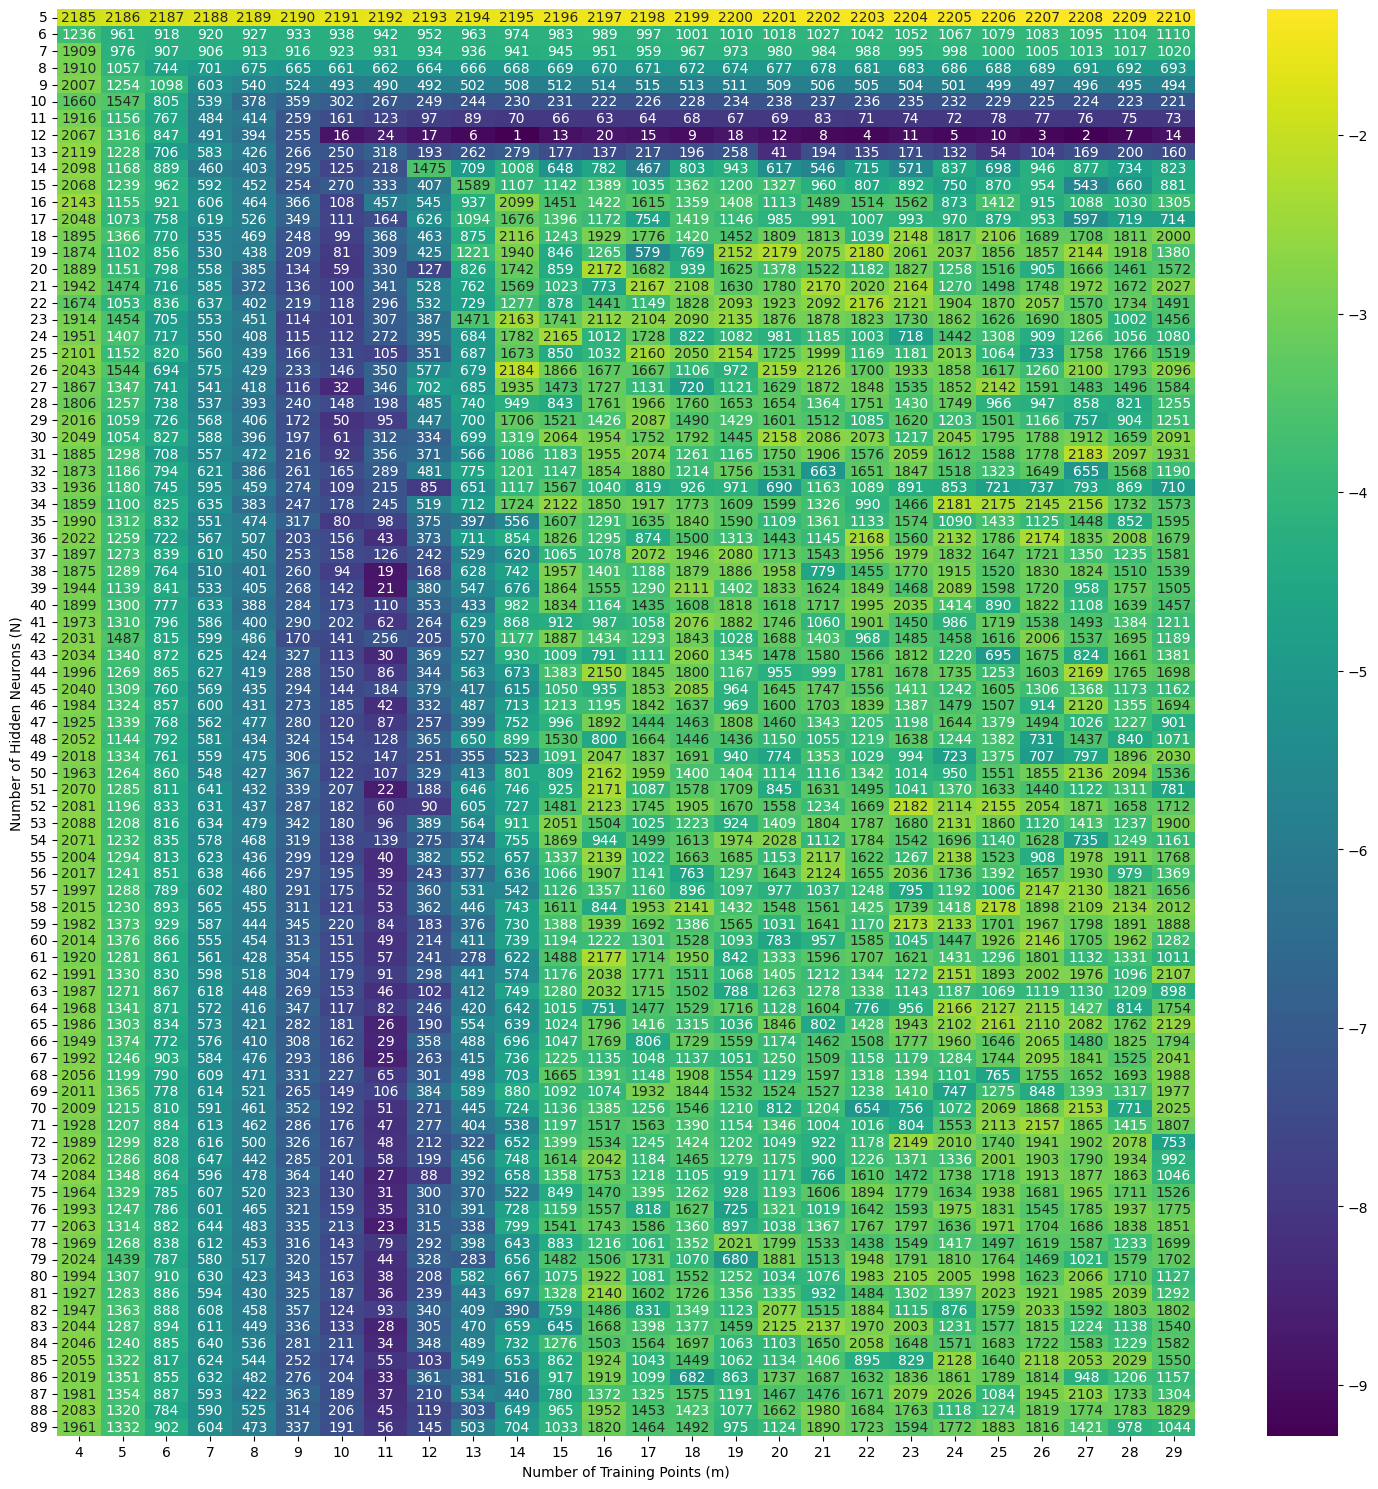

Log10(RMSE) Heatmap
(Numbers indicate rank: 1 = smallest)


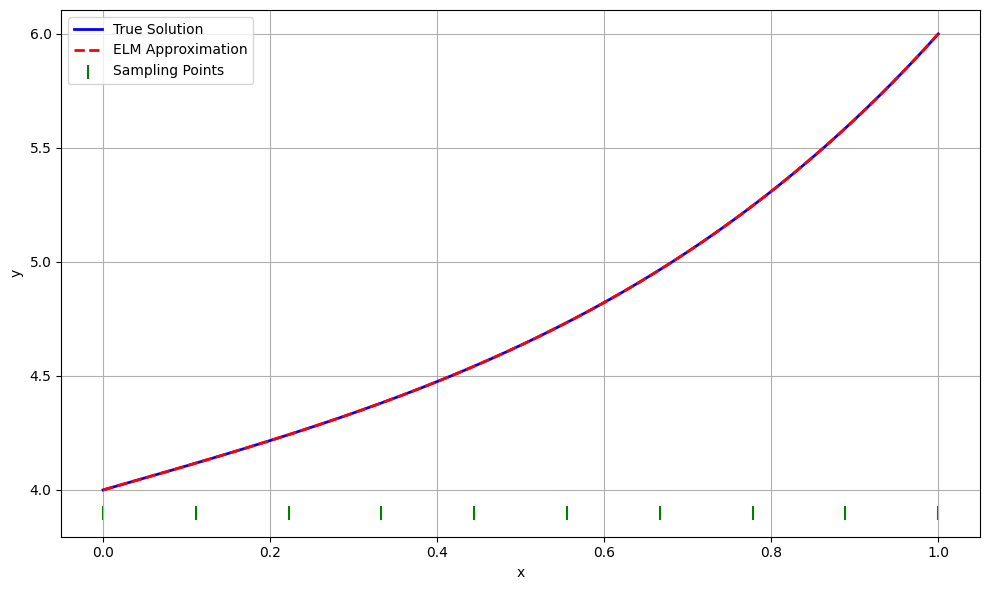

Solution Comparison (N=80, m=10)


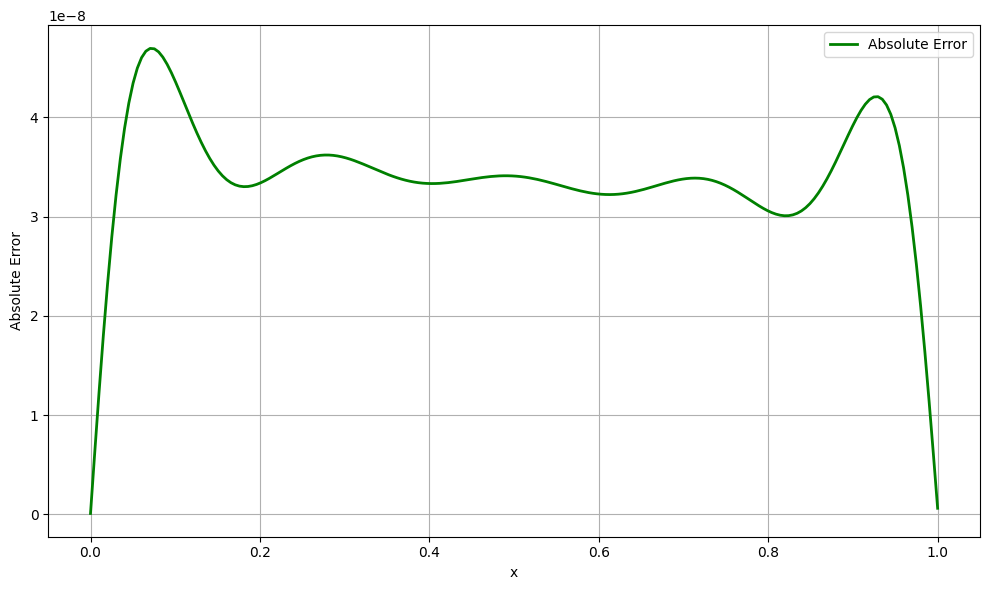

Error Distribution (N=80, m=10)
MAE: 0.0000000469
RMSE: 0.0000000343
Integral Error: 0.0000000339


<ipython-input-11-59eb460f33f9>:29: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integral_error = trapz(absolute_error, x_test)


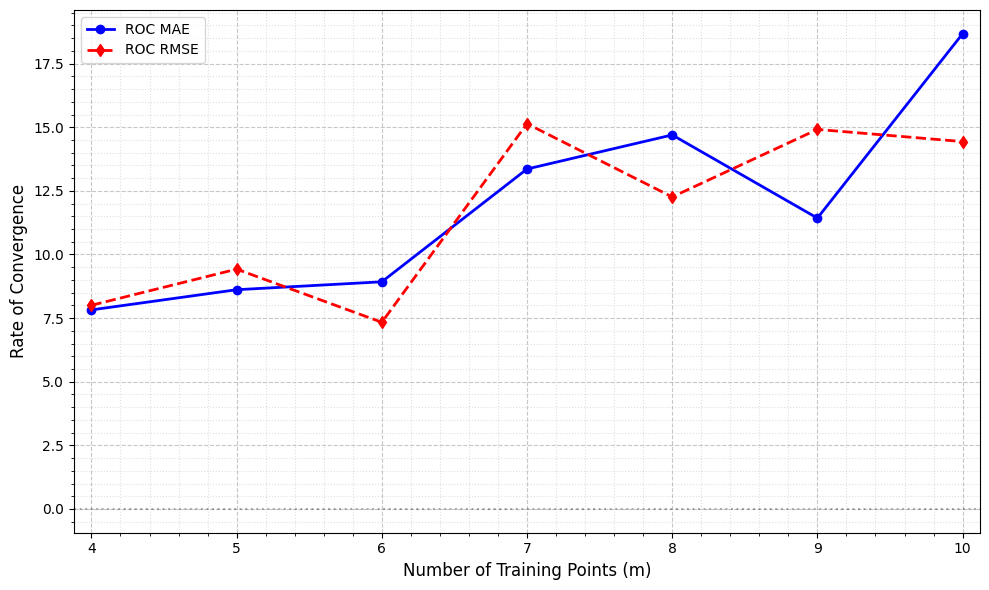

Rate of Convergence Analysis (N=80)


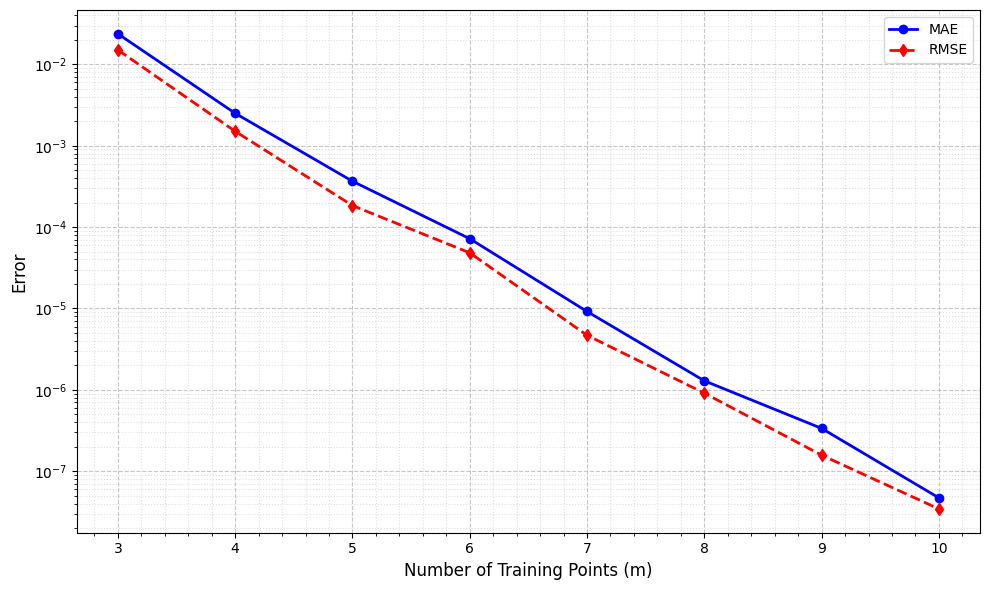

Error Analysis (N=80)

Error values up to m = 10
m values: [3, 4, 5, 6, 7, 8, 9, 10]
MAE values: [0.023787018726067366, 0.0025061423707413155, 0.00036653647107520726, 7.199684749359392e-05, 9.183709979154742e-06, 1.2902694122018943e-06, 3.357767068834505e-07, 4.6948767540300196e-08]
RMSE values: [0.015059390970533063, 0.0015058921662794839, 0.00018388332810462404, 4.828005858728188e-05, 4.6811716097682606e-06, 9.105957335810516e-07, 1.5720094168231816e-07, 3.4346598542561714e-08]

Best combination with minimum RMSE error: N=12, m=14


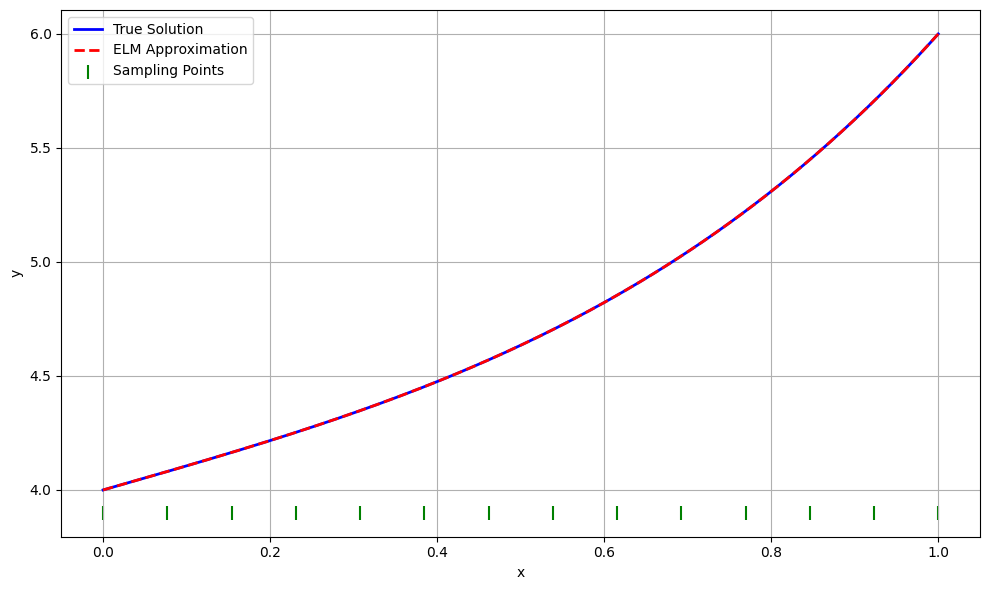

Solution Comparison (N=12, m=14)


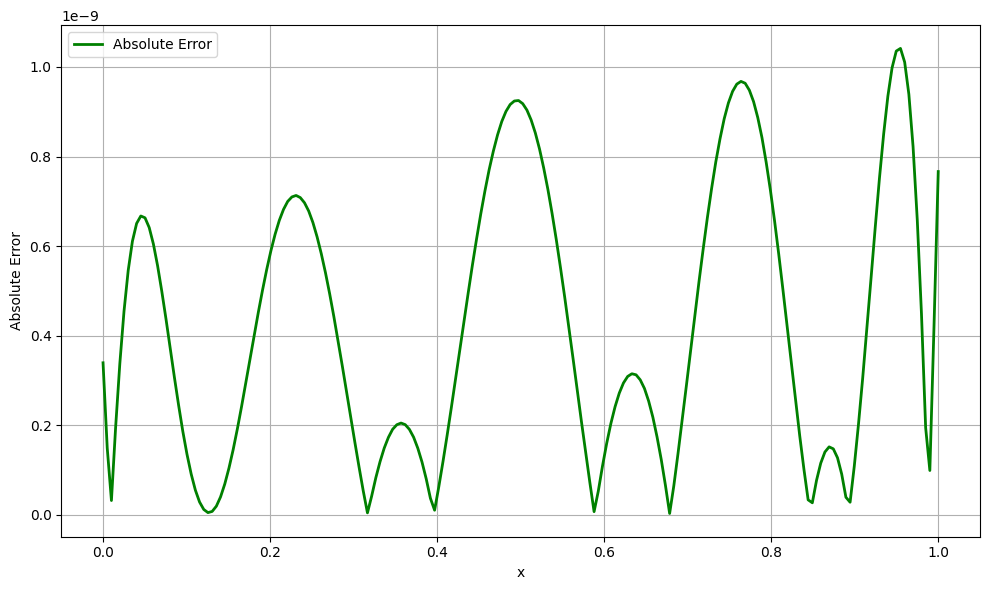

Error Distribution (N=12, m=14)
MAE: 0.0000000010
RMSE: 0.0000000005
Integral Error: 0.0000000004

Results for N = 80
    m             MAE            RMSE         ROC MAE        ROC RMSE
--------------------------------------------------------------------------------
    3    2.378702e-02    1.505939e-02             N/A             N/A
    4    2.506142e-03    1.505892e-03        7.822508        8.004031
    5    3.665365e-04    1.838833e-04        8.615091        9.423706
    6    7.199685e-05    4.828006e-05        8.926403        7.334749
    7    9.183710e-06    4.681172e-06       13.358300       15.137593
    8    1.290269e-06    9.105957e-07       14.697519       12.260822
    9    3.357767e-07    1.572009e-07       11.429150       14.913643
   10    4.694877e-08    3.434660e-08       18.672929       14.436356


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_bvp, trapz
import seaborn as sns

seed = 42
# Parameters
a, b = 0, 1
A, B = 4, 6
wb = 2

# Define ranges for N and m
N_values = range(5, 90, 1)
m_values = range(3, 30)
m_heatmap_values = range(4, 30)  # Heatmap starts from m = 4

def a2(x): return 1
def a1(x): return 0
def a0(x): return -x
def f_func(x, y): return x
def sigmoid(x): return 1 / (1 + np.exp(-x))
def MAE(y_true, y_pred): return np.max(np.abs(y_true - y_pred))
def RMSE(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def convergence_rate(E_n1, E_n2, n1, n2): return np.log(E_n1 / E_n2) / np.log(n2 / n1)

def calculate_integral_error(y_true, y_approx, x_test):
  absolute_error = np.abs(y_true - y_approx)
  integral_error = trapz(absolute_error, x_test)
  return integral_error

def elm_solver(m, N, a, b, A, B, u, w):
  x_train = np.linspace(a, b, m)
  f_x = f_func(x_train, 0)

  H = np.zeros((m+2, N))
  for i in range(m):
      x = x_train[i]
      for j in range(N):
          phi = sigmoid(x * u[j] + w[j])
          phi_prime = u[j] * sigmoid(x * u[j] + w[j]) * (1 - sigmoid(x * u[j] + w[j]))
          phi_double_prime = (u[j]**2) * sigmoid(x * u[j] + w[j]) * (1 - sigmoid(x * u[j] + w[j])) * (1 - 2 * sigmoid(x * u[j] + w[j]))
          H[i, j] = a2(x) * phi_double_prime + a1(x) * phi_prime + a0(x) * phi

  for j in range(N):
      H[-2, j] = sigmoid(a * u[j] + w[j])
      H[-1, j] = sigmoid(b * u[j] + w[j])

  beta = np.zeros(m+2)
  beta[:m] = f_x
  beta[-2] = A
  beta[-1] = B

  V = np.linalg.pinv(H) @ beta

  def y_approx(x):
      return sum(V[j] * sigmoid(u[j] * x + w[j]) for j in range(N))

  return y_approx

def numerical_solution(a, b, A, B):
  def ode_system(x, Y):
      y, dy = Y
      d2y_dx2 = (f_func(x, y) - a1(x)*dy - a0(x)*y) / a2(x)
      return np.vstack((dy, d2y_dx2))

  x_init = np.linspace(a, b, 10)
  Y_init = np.zeros((2, x_init.size))
  Y_init[0] = A + (B - A) * (x_init - a) / (b - a)

  def bc(Y_a, Y_b):
      return np.array([Y_a[0] - A, Y_b[0] - B])

  sol = solve_bvp(ode_system, bc, x_init, Y_init, tol=1e-10, max_nodes=1000)

  if sol.status != 0:
      print("WARNING: The BVP solver did not converge!")

  def y_num(x):
      return sol.sol(x)[0]

  return y_num

# Compute numerical solution
y_num = numerical_solution(a, b, A, B)
x_test = np.linspace(a, b, 200)
y_true = y_num(x_test)

# Initialize heatmap data and comprehensive results
heatmap_data = np.zeros((len(N_values), len(m_heatmap_values)))  # Adjusted for heatmap
all_results = []

# Main analysis loop
for i, N in enumerate(N_values):
  np.random.seed(seed)
  u = np.random.uniform(-wb, wb, N)
  w = np.random.uniform(-wb, wb, N)

  prev_mae = None
  prev_rms = None

  for j, m in enumerate(m_values):
      y_approx_func = elm_solver(m, N, a, b, A, B, u, w)
      y_approx = y_approx_func(x_test)

      mae = MAE(y_true, y_approx)
      rms = RMSE(y_true, y_approx)

      # Store RMSE in heatmap data only for m_heatmap_values
      if m in m_heatmap_values:
          heatmap_data[i, m - 4] = rms  # Adjust index for heatmap

      if prev_mae is not None and prev_rms is not None:
          conv_rate_mae = convergence_rate(prev_mae, mae, m-1, m)
          conv_rate_rms = convergence_rate(prev_rms, rms, m-1, m)
      else:
          conv_rate_mae = np.nan
          conv_rate_rms = np.nan

      all_results.append({
          'Parameters (N,m)': f"({N},{m})",
          'MAE': mae,
          'RMSE': rms,
          'ROC MAE': conv_rate_mae,
          'ROC RMSE': conv_rate_rms
      })

      prev_mae = mae
      prev_rms = rms

# Create comprehensive DataFrame
df_all = pd.DataFrame(all_results)

# Format convergence rates
df_all['ROC MAE'] = df_all['ROC MAE'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df_all['ROC RMSE'] = df_all['ROC RMSE'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")

def plot_specific_solution(N, m):
  # Generate weights
  np.random.seed(seed)
  u = np.random.uniform(-wb, wb, N)
  w = np.random.uniform(-wb, wb, N)

  # Get approximate solution
  y_approx_func = elm_solver(m, N, a, b, A, B, u, w)
  y_approx = y_approx_func(x_test)

  # Generate sampling points
  x_train = np.linspace(a, b, m)

  # Plot solution comparison
  plt.figure(figsize=(10, 6))
  plt.plot(x_test, y_true, 'b-', label='True Solution', linewidth=2)
  plt.plot(x_test, y_approx, 'r--', label='ELM Approximation', linewidth=2)
  plt.scatter(x_train, [plt.ylim()[0]]*len(x_train), color='g', marker='|',
              s=100, label='Sampling Points')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  print(f'Solution Comparison (N={N}, m={m})')  # Print title

  # Plot error in a separate figure
  plt.figure(figsize=(10, 6))
  error = np.abs(y_true - y_approx)
  plt.plot(x_test, error, 'g-', label='Absolute Error', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('Absolute Error')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  print(f'Error Distribution (N={N}, m={m})')  # Print title

  # Calculate and print error metrics
  mae = MAE(y_true, y_approx)
  rms = RMSE(y_true, y_approx)
  integral_error = calculate_integral_error(y_true, y_approx, x_test)
  print(f"MAE: {mae:.10f}")
  print(f"RMSE: {rms:.10f}")
  print(f"Integral Error: {integral_error:.10f}")

# For the heatmap
plt.figure(figsize=(15, 15))

# Convert RMSE errors to log scale
log_heatmap_data = np.log10(heatmap_data)

# Create ranking overlay based on log values (1 for smallest)
heatmap_ranked = np.zeros_like(log_heatmap_data)
flat_indices = np.argsort(log_heatmap_data.flatten())
for rank, idx in enumerate(flat_indices, 1):
  i, j = np.unravel_index(idx, log_heatmap_data.shape)
  heatmap_ranked[i, j] = rank

sns.heatmap(log_heatmap_data,
          xticklabels=list(m_heatmap_values),
          yticklabels=list(N_values),
          cmap='viridis',
          annot=heatmap_ranked,
          fmt='.0f',
          annot_kws={'size': 10})

plt.xlabel('Number of Training Points (m)')
plt.ylabel('Number of Hidden Neurons (N)')
plt.tight_layout()
plt.show()
print('Log10(RMSE) Heatmap\n(Numbers indicate rank: 1 = smallest)')  # Print title

# Plot for specific N, m values
specific_N = 80
specific_m = 10
plot_specific_solution(specific_N, specific_m)

# Extract data for a fixed N
N_fixed = 80
df_fixed_N = df_all[df_all['Parameters (N,m)'].str.startswith(f'({N_fixed},')]

# Create lists to store the values
m_vals = list(m_values)[1:8]  # Exclude first m value
ros_mae_vals = []
ros_rms_vals = []

# Extract values for the fixed N with error handling
for m in m_vals:
  try:
      row = df_fixed_N[df_fixed_N['Parameters (N,m)'] == f'({N_fixed},{m})']
      if not row.empty:
          ros_mae_vals.append(float(row['ROC MAE'].iloc[0]) if row['ROC MAE'].iloc[0] != 'N/A' else np.nan)
          ros_rms_vals.append(float(row['ROC RMSE'].iloc[0]) if row['ROC RMSE'].iloc[0] != 'N/A' else np.nan)
      else:
          ros_mae_vals.append(np.nan)
          ros_rms_vals.append(np.nan)
  except Exception as e:
      print(f"Error processing m={m}: {e}")
      ros_mae_vals.append(np.nan)
      ros_rms_vals.append(np.nan)

# Create the academic plot for Rate of Convergence
plt.figure(figsize=(10, 6))
plt.plot(m_vals, ros_mae_vals, 'bo-', label='ROC MAE', linewidth=2, markersize=6)
plt.plot(m_vals, ros_rms_vals, 'rd--', label='ROC RMSE', linewidth=2, markersize=6)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Training Points (m)', fontsize=12)
plt.ylabel('Rate of Convergence', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()
plt.margins(x=0.02)
plt.axhline(y=0, color='k', linestyle=':', alpha=0.3)
plt.xticks(m_vals, fontsize=10)
plt.yticks(fontsize=10)
plt.box(True)
plt.tight_layout()
plt.show()
print(f'Rate of Convergence Analysis (N={N_fixed})')  # Print title

# Create a new plot for MAE and RMSE vs m
plt.figure(figsize=(10, 6))

# Get m values and corresponding errors up to m=15
m_max = 10  # Set maximum m value
m_vals = list(m_values)[:m_max-2]  # Subtract 2 because m_values starts from 3
mae_vals = []
rms_vals = []

for m in m_vals:
  row = df_fixed_N[df_fixed_N['Parameters (N,m)'] == f'({N_fixed},{m})']
  if not row.empty:
      mae_vals.append(row['MAE'].iloc[0])
      rms_vals.append(row['RMSE'].iloc[0])

# Plot both errors
plt.plot(m_vals, mae_vals, 'bo-', label='MAE', linewidth=2, markersize=6)
plt.plot(m_vals, rms_vals, 'rd--', label='RMSE', linewidth=2, markersize=6)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Training Points (m)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()
plt.yscale('log')
plt.box(True)
plt.tight_layout()
plt.show()
print(f'Error Analysis (N={N_fixed})')  # Print title

# Print the actual values being plotted
print("\nError values up to m =", m_max)
print("m values:", m_vals)
print("MAE values:", mae_vals)
print("RMSE values:", rms_vals)

# Find N,m with minimum RMSE error from the heatmap_data
min_idx = np.unravel_index(np.argmin(heatmap_data), heatmap_data.shape)
best_N = list(N_values)[min_idx[0]]
best_m = list(m_heatmap_values)[min_idx[1]]  # Adjusted to use m_heatmap_values

print(f"\nBest combination with minimum RMSE error: N={best_N}, m={best_m}")

# Plot the error distribution for the best N and m
plot_specific_solution(best_N, best_m)

print("\nResults for N =", N_fixed)
print("=" * 80)
print(f"{'m':>5} {'MAE':>15} {'RMSE':>15} {'ROC MAE':>15} {'ROC RMSE':>15}")
print("-" * 80)

for idx, m in enumerate(m_vals):
  mae = mae_vals[idx]
  rms = rms_vals[idx]

  # Calculate ROC (Rate of Success) for points after the first one
  if idx > 0:
      ros_mae = np.log(mae_vals[idx-1] / mae) / np.log(m / m_vals[idx-1])
      ros_rms = np.log(rms_vals[idx-1] / rms) / np.log(m / m_vals[idx-1])
      ros_mae_str = f"{ros_mae:15.6f}"
      ros_rms_str = f"{ros_rms:15.6f}"
  else:
      ros_mae_str = f"{'N/A':>15}"
      ros_rms_str = f"{'N/A':>15}"

  print(f"{m:5d} {mae:15.6e} {rms:15.6e} {ros_mae_str} {ros_rms_str}")

print("=" * 80)

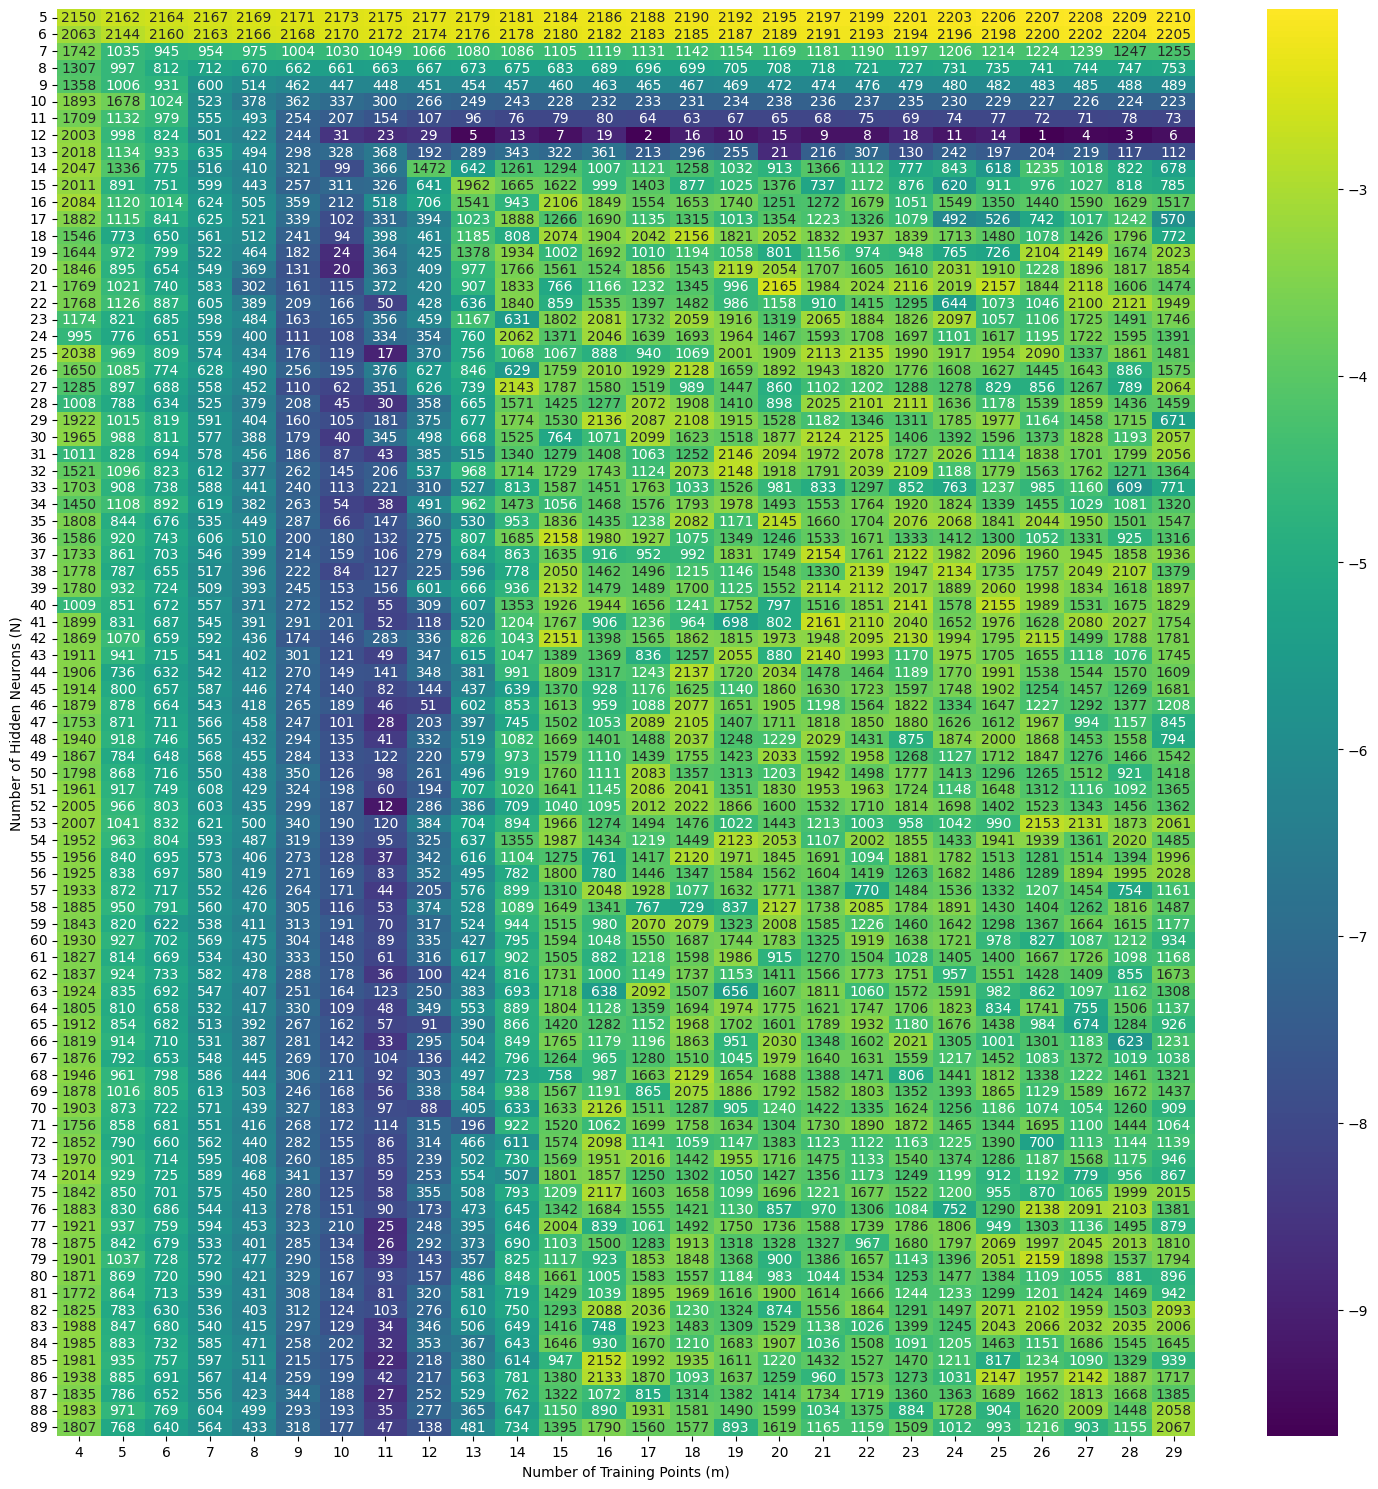

Log10(RMSE) Heatmap
(Numbers indicate rank: 1 = smallest)


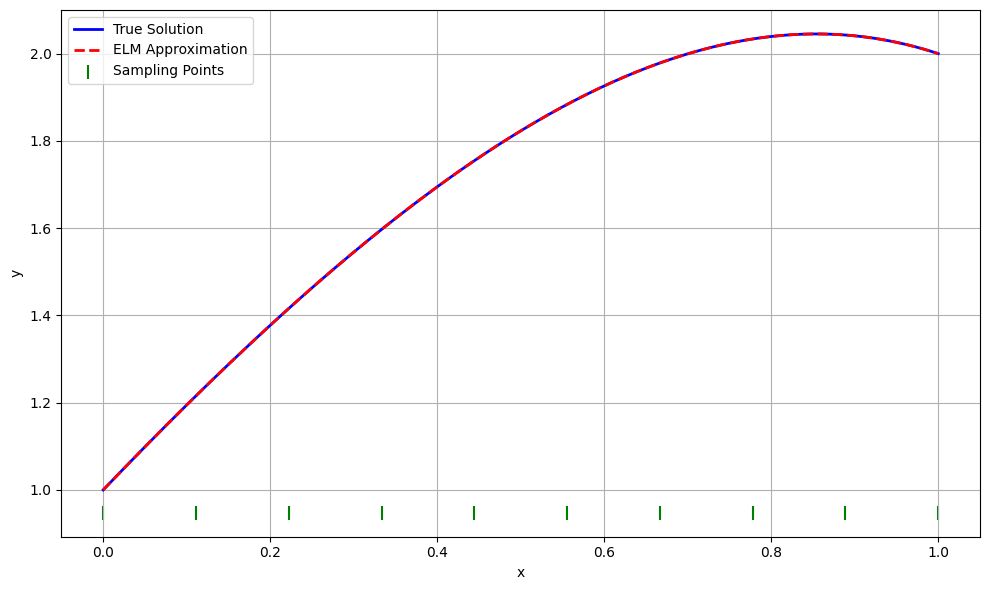

Solution Comparison (N=80, m=10)


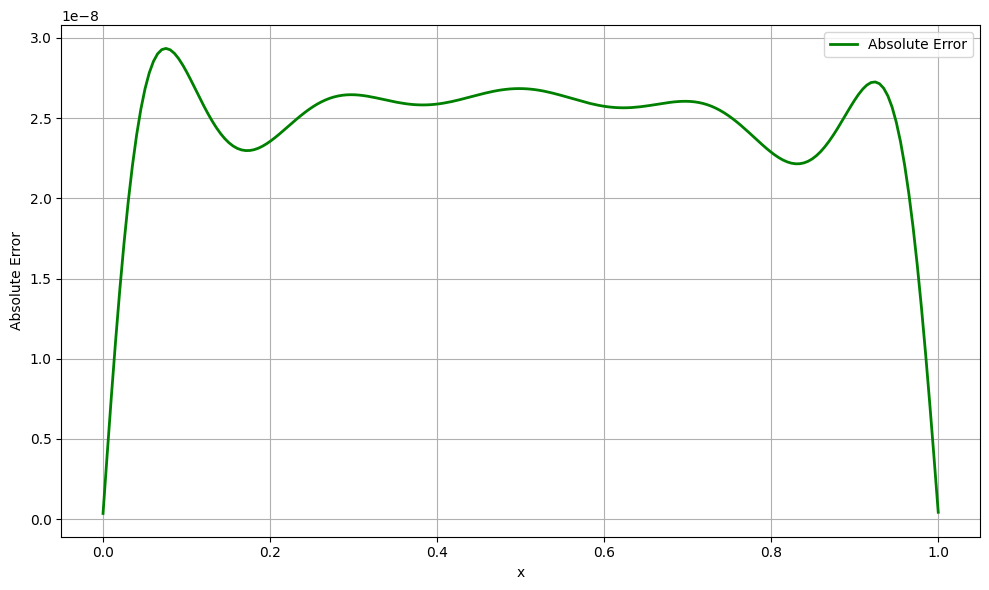

Error Distribution (N=80, m=10)
MAE: 0.0000000293
RMSE: 0.0000000248
Integral Error: 0.0000000245


<ipython-input-12-2ac713d154a1>:29: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integral_error = trapz(absolute_error, x_test)


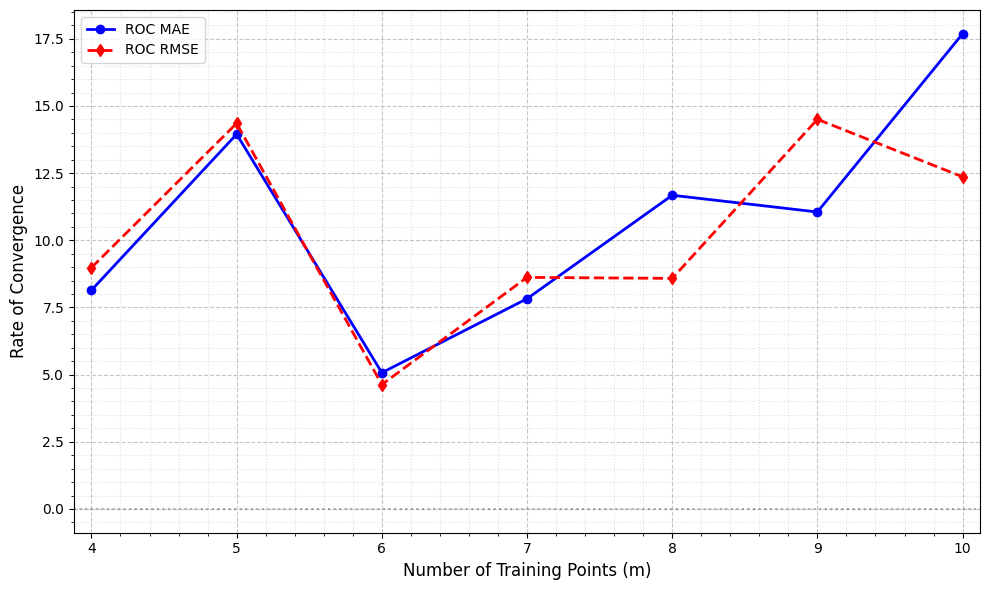

Rate of Convergence Analysis (N=80)


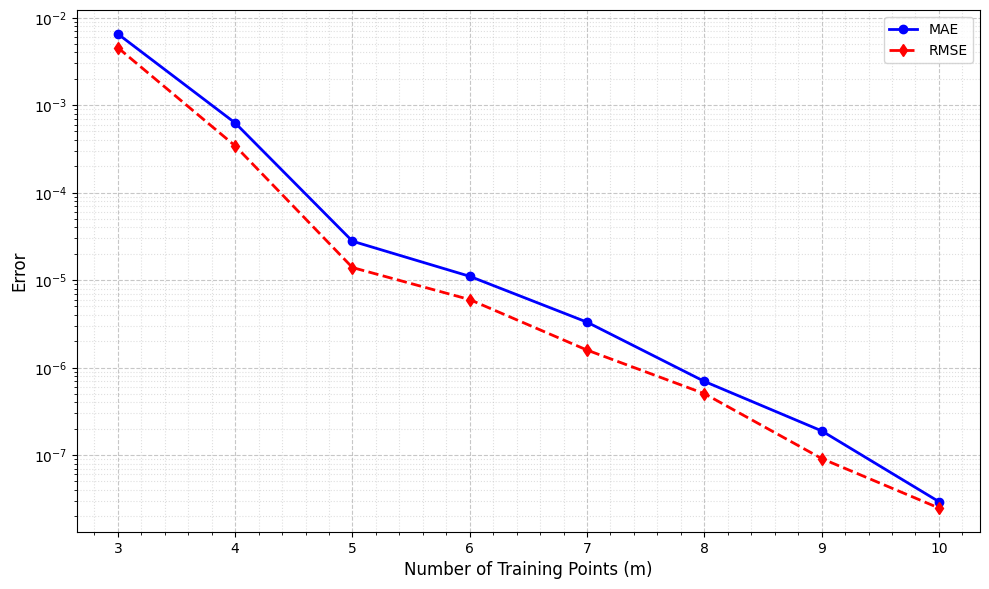

Error Analysis (N=80)

Error values up to m = 10
m values: [3, 4, 5, 6, 7, 8, 9, 10]
MAE values: [0.006517879675780325, 0.0006261749814593376, 2.785503546665069e-05, 1.1049947035157714e-05, 3.3075445990959906e-06, 6.955794176199959e-07, 1.8919278765849867e-07, 2.9347166918824996e-08]
RMSE values: [0.004539878719264449, 0.0003425740665766606, 1.3925972808210543e-05, 5.988083269049171e-06, 1.5856720288067191e-06, 5.041006404303948e-07, 9.13432659346476e-08, 2.483214790773606e-08]

Best combination with minimum RMSE error: N=12, m=26


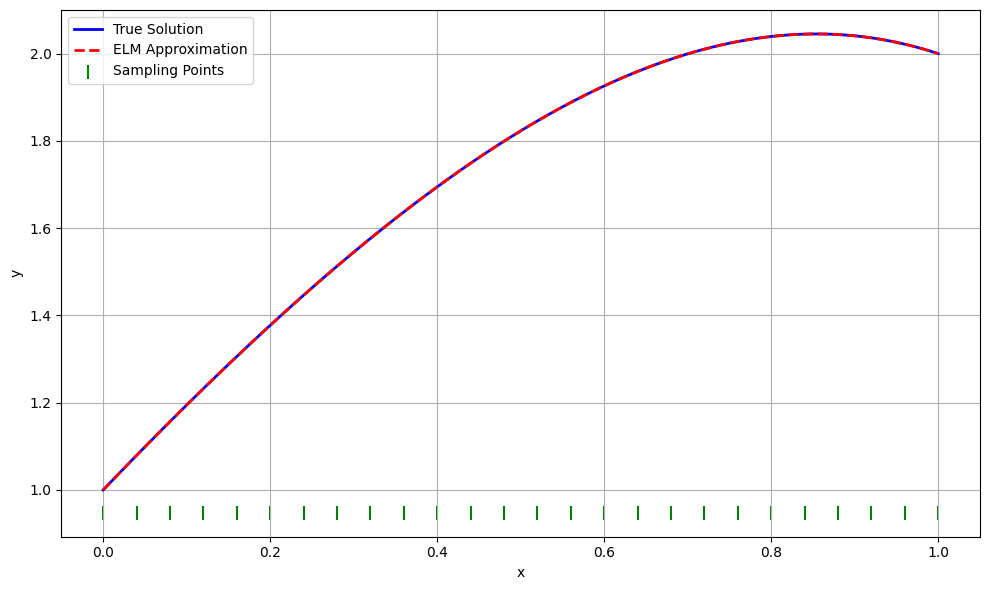

Solution Comparison (N=12, m=26)


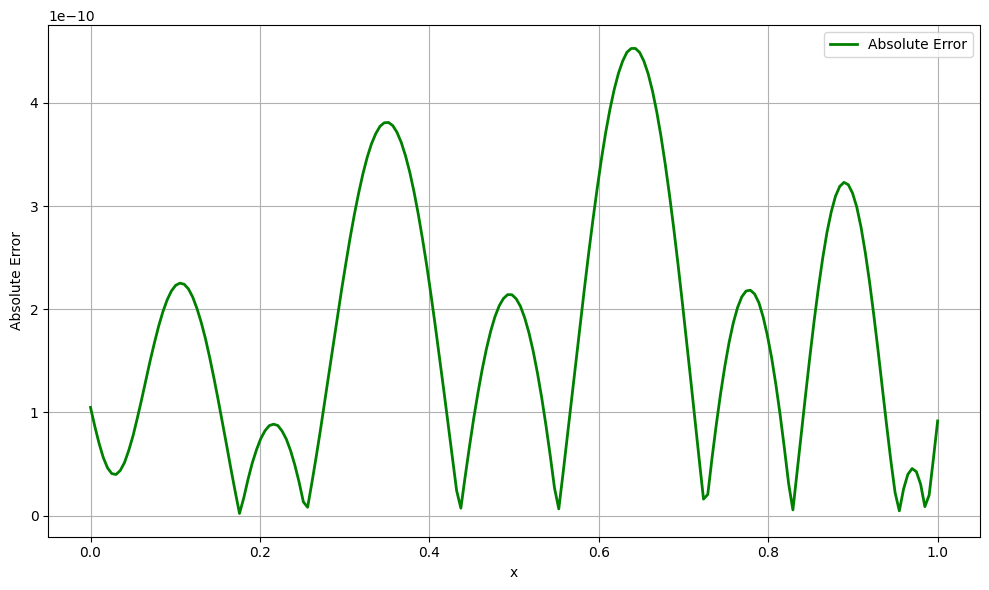

Error Distribution (N=12, m=26)
MAE: 0.0000000005
RMSE: 0.0000000002
Integral Error: 0.0000000002

Results for N = 80
    m             MAE            RMSE         ROC MAE        ROC RMSE
--------------------------------------------------------------------------------
    3    6.517880e-03    4.539879e-03             N/A             N/A
    4    6.261750e-04    3.425741e-04        8.143276        8.982721
    5    2.785504e-05    1.392597e-05       13.948940       14.352789
    6    1.104995e-05    5.988083e-06        5.071195        4.629098
    7    3.307545e-06    1.585672e-06        7.824938        8.619898
    8    6.955794e-07    5.041006e-07       11.676776        8.582159
    9    1.891928e-07    9.134327e-08       11.054042       14.502525
   10    2.934717e-08    2.483215e-08       17.687561       12.362178


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_bvp, trapz
import seaborn as sns

seed = 42
# Parameters
a, b = 0, 1
A, B = 1, 2
wb = 2

# Define ranges for N and m
N_values = range(5, 90, 1)
m_values = range(3, 30)
m_heatmap_values = range(4, 30)  # Heatmap starts from m = 4

def a2(x): return 1
def a1(x): return 0
def a0(x): return np.exp(x)
def f_func(x, y): return np.sin(x)
def sigmoid(x): return 1 / (1 + np.exp(-x))
def MAE(y_true, y_pred): return np.max(np.abs(y_true - y_pred))
def RMSE(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def convergence_rate(E_n1, E_n2, n1, n2): return np.log(E_n1 / E_n2) / np.log(n2 / n1)

def calculate_integral_error(y_true, y_approx, x_test):
  absolute_error = np.abs(y_true - y_approx)
  integral_error = trapz(absolute_error, x_test)
  return integral_error

def elm_solver(m, N, a, b, A, B, u, w):
  x_train = np.linspace(a, b, m)
  f_x = f_func(x_train, 0)

  H = np.zeros((m+2, N))
  for i in range(m):
      x = x_train[i]
      for j in range(N):
          phi = sigmoid(x * u[j] + w[j])
          phi_prime = u[j] * sigmoid(x * u[j] + w[j]) * (1 - sigmoid(x * u[j] + w[j]))
          phi_double_prime = (u[j]**2) * sigmoid(x * u[j] + w[j]) * (1 - sigmoid(x * u[j] + w[j])) * (1 - 2 * sigmoid(x * u[j] + w[j]))
          H[i, j] = a2(x) * phi_double_prime + a1(x) * phi_prime + a0(x) * phi

  for j in range(N):
      H[-2, j] = sigmoid(a * u[j] + w[j])
      H[-1, j] = sigmoid(b * u[j] + w[j])

  beta = np.zeros(m+2)
  beta[:m] = f_x
  beta[-2] = A
  beta[-1] = B

  V = np.linalg.pinv(H) @ beta

  def y_approx(x):
      return sum(V[j] * sigmoid(u[j] * x + w[j]) for j in range(N))

  return y_approx

def numerical_solution(a, b, A, B):
  def ode_system(x, Y):
      y, dy = Y
      d2y_dx2 = (f_func(x, y) - a1(x)*dy - a0(x)*y) / a2(x)
      return np.vstack((dy, d2y_dx2))

  x_init = np.linspace(a, b, 10)
  Y_init = np.zeros((2, x_init.size))
  Y_init[0] = A + (B - A) * (x_init - a) / (b - a)

  def bc(Y_a, Y_b):
      return np.array([Y_a[0] - A, Y_b[0] - B])

  sol = solve_bvp(ode_system, bc, x_init, Y_init, tol=1e-10, max_nodes=1000)

  if sol.status != 0:
      print("WARNING: The BVP solver did not converge!")

  def y_num(x):
      return sol.sol(x)[0]

  return y_num

# Compute numerical solution
y_num = numerical_solution(a, b, A, B)
x_test = np.linspace(a, b, 200)
y_true = y_num(x_test)

# Initialize heatmap data and comprehensive results
heatmap_data = np.zeros((len(N_values), len(m_heatmap_values)))  # Adjusted for heatmap
all_results = []

# Main analysis loop
for i, N in enumerate(N_values):
  np.random.seed(seed)
  u = np.random.uniform(-wb, wb, N)
  w = np.random.uniform(-wb, wb, N)

  prev_mae = None
  prev_rms = None

  for j, m in enumerate(m_values):
      y_approx_func = elm_solver(m, N, a, b, A, B, u, w)
      y_approx = y_approx_func(x_test)

      mae = MAE(y_true, y_approx)
      rms = RMSE(y_true, y_approx)

      # Store RMSE in heatmap data only for m_heatmap_values
      if m in m_heatmap_values:
          heatmap_data[i, m - 4] = rms  # Adjust index for heatmap

      if prev_mae is not None and prev_rms is not None:
          conv_rate_mae = convergence_rate(prev_mae, mae, m-1, m)
          conv_rate_rms = convergence_rate(prev_rms, rms, m-1, m)
      else:
          conv_rate_mae = np.nan
          conv_rate_rms = np.nan

      all_results.append({
          'Parameters (N,m)': f"({N},{m})",
          'MAE': mae,
          'RMSE': rms,
          'ROC MAE': conv_rate_mae,
          'ROC RMSE': conv_rate_rms
      })

      prev_mae = mae
      prev_rms = rms

# Create comprehensive DataFrame
df_all = pd.DataFrame(all_results)

# Format convergence rates
df_all['ROC MAE'] = df_all['ROC MAE'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
df_all['ROC RMSE'] = df_all['ROC RMSE'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")

def plot_specific_solution(N, m):
  # Generate weights
  np.random.seed(seed)
  u = np.random.uniform(-wb, wb, N)
  w = np.random.uniform(-wb, wb, N)

  # Get approximate solution
  y_approx_func = elm_solver(m, N, a, b, A, B, u, w)
  y_approx = y_approx_func(x_test)

  # Generate sampling points
  x_train = np.linspace(a, b, m)

  # Plot solution comparison
  plt.figure(figsize=(10, 6))
  plt.plot(x_test, y_true, 'b-', label='True Solution', linewidth=2)
  plt.plot(x_test, y_approx, 'r--', label='ELM Approximation', linewidth=2)
  plt.scatter(x_train, [plt.ylim()[0]]*len(x_train), color='g', marker='|',
              s=100, label='Sampling Points')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  print(f'Solution Comparison (N={N}, m={m})')  # Print title

  # Plot error in a separate figure
  plt.figure(figsize=(10, 6))
  error = np.abs(y_true - y_approx)
  plt.plot(x_test, error, 'g-', label='Absolute Error', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('Absolute Error')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  print(f'Error Distribution (N={N}, m={m})')  # Print title

  # Calculate and print error metrics
  mae = MAE(y_true, y_approx)
  rms = RMSE(y_true, y_approx)
  integral_error = calculate_integral_error(y_true, y_approx, x_test)
  print(f"MAE: {mae:.10f}")
  print(f"RMSE: {rms:.10f}")
  print(f"Integral Error: {integral_error:.10f}")

# For the heatmap
plt.figure(figsize=(15, 15))

# Convert RMSE errors to log scale
log_heatmap_data = np.log10(heatmap_data)

# Create ranking overlay based on log values (1 for smallest)
heatmap_ranked = np.zeros_like(log_heatmap_data)
flat_indices = np.argsort(log_heatmap_data.flatten())
for rank, idx in enumerate(flat_indices, 1):
  i, j = np.unravel_index(idx, log_heatmap_data.shape)
  heatmap_ranked[i, j] = rank

sns.heatmap(log_heatmap_data,
          xticklabels=list(m_heatmap_values),
          yticklabels=list(N_values),
          cmap='viridis',
          annot=heatmap_ranked,
          fmt='.0f',
          annot_kws={'size': 10})

plt.xlabel('Number of Training Points (m)')
plt.ylabel('Number of Hidden Neurons (N)')
plt.tight_layout()
plt.show()
print('Log10(RMSE) Heatmap\n(Numbers indicate rank: 1 = smallest)')  # Print title

# Plot for specific N, m values
specific_N = 80
specific_m = 10
plot_specific_solution(specific_N, specific_m)

# Extract data for a fixed N
N_fixed = 80
df_fixed_N = df_all[df_all['Parameters (N,m)'].str.startswith(f'({N_fixed},')]

# Create lists to store the values
m_vals = list(m_values)[1:8]  # Exclude first m value
ros_mae_vals = []
ros_rms_vals = []

# Extract values for the fixed N with error handling
for m in m_vals:
  try:
      row = df_fixed_N[df_fixed_N['Parameters (N,m)'] == f'({N_fixed},{m})']
      if not row.empty:
          ros_mae_vals.append(float(row['ROC MAE'].iloc[0]) if row['ROC MAE'].iloc[0] != 'N/A' else np.nan)
          ros_rms_vals.append(float(row['ROC RMSE'].iloc[0]) if row['ROC RMSE'].iloc[0] != 'N/A' else np.nan)
      else:
          ros_mae_vals.append(np.nan)
          ros_rms_vals.append(np.nan)
  except Exception as e:
      print(f"Error processing m={m}: {e}")
      ros_mae_vals.append(np.nan)
      ros_rms_vals.append(np.nan)

# Create the academic plot for Rate of Convergence
plt.figure(figsize=(10, 6))
plt.plot(m_vals, ros_mae_vals, 'bo-', label='ROC MAE', linewidth=2, markersize=6)
plt.plot(m_vals, ros_rms_vals, 'rd--', label='ROC RMSE', linewidth=2, markersize=6)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Training Points (m)', fontsize=12)
plt.ylabel('Rate of Convergence', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()
plt.margins(x=0.02)
plt.axhline(y=0, color='k', linestyle=':', alpha=0.3)
plt.xticks(m_vals, fontsize=10)
plt.yticks(fontsize=10)
plt.box(True)
plt.tight_layout()
plt.show()
print(f'Rate of Convergence Analysis (N={N_fixed})')  # Print title

# Create a new plot for MAE and RMSE vs m
plt.figure(figsize=(10, 6))

# Get m values and corresponding errors up to m=15
m_max = 10  # Set maximum m value
m_vals = list(m_values)[:m_max-2]  # Subtract 2 because m_values starts from 3
mae_vals = []
rms_vals = []

for m in m_vals:
  row = df_fixed_N[df_fixed_N['Parameters (N,m)'] == f'({N_fixed},{m})']
  if not row.empty:
      mae_vals.append(row['MAE'].iloc[0])
      rms_vals.append(row['RMSE'].iloc[0])

# Plot both errors
plt.plot(m_vals, mae_vals, 'bo-', label='MAE', linewidth=2, markersize=6)
plt.plot(m_vals, rms_vals, 'rd--', label='RMSE', linewidth=2, markersize=6)

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Training Points (m)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, which='minor', linestyle=':', alpha=0.4)
plt.minorticks_on()
plt.yscale('log')
plt.box(True)
plt.tight_layout()
plt.show()
print(f'Error Analysis (N={N_fixed})')  # Print title

# Print the actual values being plotted
print("\nError values up to m =", m_max)
print("m values:", m_vals)
print("MAE values:", mae_vals)
print("RMSE values:", rms_vals)

# Find N,m with minimum RMSE error from the heatmap_data
min_idx = np.unravel_index(np.argmin(heatmap_data), heatmap_data.shape)
best_N = list(N_values)[min_idx[0]]
best_m = list(m_heatmap_values)[min_idx[1]]  # Adjusted to use m_heatmap_values

print(f"\nBest combination with minimum RMSE error: N={best_N}, m={best_m}")

# Plot the error distribution for the best N and m
plot_specific_solution(best_N, best_m)

print("\nResults for N =", N_fixed)
print("=" * 80)
print(f"{'m':>5} {'MAE':>15} {'RMSE':>15} {'ROC MAE':>15} {'ROC RMSE':>15}")
print("-" * 80)

for idx, m in enumerate(m_vals):
  mae = mae_vals[idx]
  rms = rms_vals[idx]

  # Calculate ROC (Rate of Success) for points after the first one
  if idx > 0:
      ros_mae = np.log(mae_vals[idx-1] / mae) / np.log(m / m_vals[idx-1])
      ros_rms = np.log(rms_vals[idx-1] / rms) / np.log(m / m_vals[idx-1])
      ros_mae_str = f"{ros_mae:15.6f}"
      ros_rms_str = f"{ros_rms:15.6f}"
  else:
      ros_mae_str = f"{'N/A':>15}"
      ros_rms_str = f"{'N/A':>15}"

  print(f"{m:5d} {mae:15.6e} {rms:15.6e} {ros_mae_str} {ros_rms_str}")

print("=" * 80)

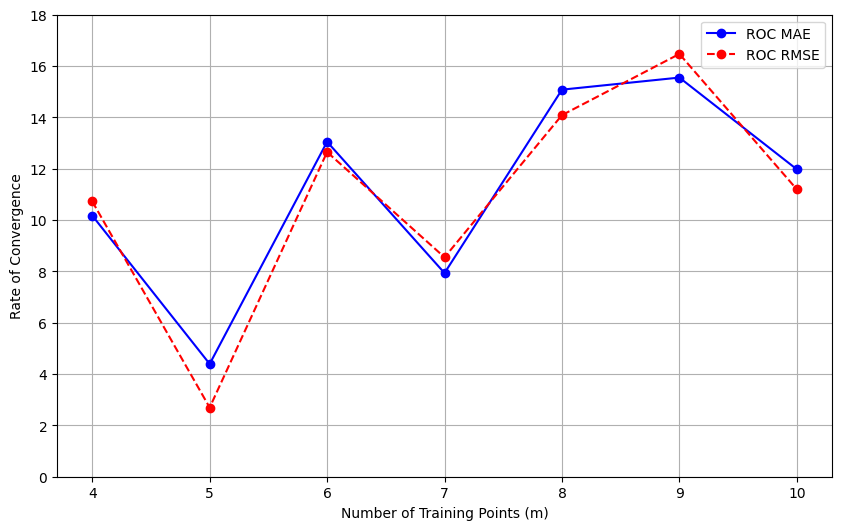

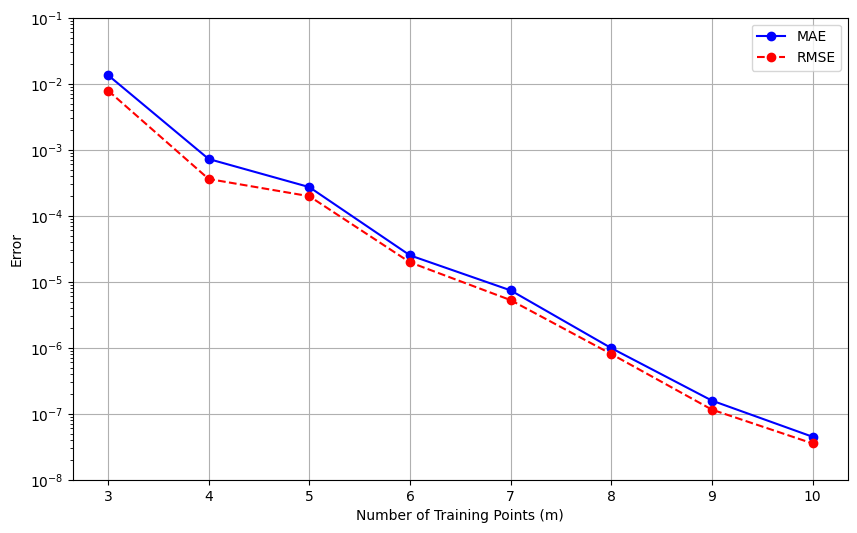

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the table
m_values = np.array([3, 4, 5, 6, 7, 8, 9, 10])
mae_values = np.array([1.350582e-02, 7.232901e-04, 2.713347e-04, 2.511339e-05, 7.396053e-06, 9.873223e-07, 1.581135e-07, 4.476352e-08])
rmse_values = np.array([7.886374e-03, 3.602900e-04, 1.974777e-04, 1.967242e-05, 5.266791e-06, 8.027263e-07, 1.153458e-07, 3.545171e-08])
mae_roc_values = np.array([np.nan, 1.017465e+01, 4.393841e+00, 1.304967e+01, 7.934906e+00, 1.508039e+01, 1.555124e+01, 1.197727e+01])
rmse_roc_values = np.array([np.nan, 1.072706e+01, 2.694605e+00, 1.265022e+01, 8.548754e+00, 1.408779e+01, 1.647163e+01, 1.119740e+01])

# Plot 1: Rate of Convergence
plt.figure(figsize=(10, 6))
plt.plot(m_values[1:], mae_roc_values[1:], marker='o', color='blue', label='ROC MAE', linestyle='-')
plt.plot(m_values[1:], rmse_roc_values[1:], marker='o', color='red', label='ROC RMSE', linestyle='--')
#plt.title('Rate of Convergence')
plt.xlabel('Number of Training Points (m)')
plt.ylabel('Rate of Convergence')
plt.xticks(m_values[1:])
plt.legend()
plt.grid()
plt.ylim(0, 18)  # Adjust y-axis limits to match the style
plt.show()

# Plot 2: Error
plt.figure(figsize=(10, 6))
plt.plot(m_values, mae_values, marker='o', color='blue', label='MAE', linestyle='-')
plt.plot(m_values, rmse_values, marker='o', color='red', label='RMSE', linestyle='--')
plt.yscale('log')  # Set y-axis to logarithmic scale
#plt.title('Error')
plt.xlabel('Number of Training Points (m)')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.ylim(1e-8, 1e-1)  # Adjust y-axis limits to match the style
plt.show()